## Dependencies

In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json
import importlib


device = torch.device("cuda:0")

## Grab all of our topnet utilities

In [2]:
# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
# importlib.reload(topnet)

In [ ]:
# Adjust threshold and run again !

## Load Malaria Cell Data

In [4]:
datadir = '/home/ephy/Projects/tda_convolution/data/'
generate_data=False
if generate_data:
    infected = glob.glob('../data/original/malaria/Parasitized/*.png')
    uninfected = glob.glob('../data/original/malaria/Uninfected/*.png')
    data = []
    labels = []

    for i in infected:
        try:

            image = cv2.imread(i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            data.append(np.array(resize_img))
            labels.append(1)


        except AttributeError:
            continue

    for u in uninfected:
        try:

            image = cv2.imread(u)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            data.append(np.array(resize_img))
            labels.append(0)

        except AttributeError:
            continue

    cells = np.array(data)
    labels = np.array(labels)

    classes=np.unique(labels)
    labels = np.array([[int(n) for n in x==classes] for x in labels])
    cells = cells/255
    cells = np.dot(cells[...,:3], [0.299, 0.587, 0.114]) # gray scale to known config

    n = np.arange(cells.shape[0])
    np.random.shuffle(n)
    cells = cells[n]
    labels = labels[n]
    cells = cells.astype(np.float32)
    labels = labels.astype(np.float32)

    train_X , test_X , train_y , test_y = train_test_split(cells , labels , 
                                                test_size = 0.2 ,
                                                random_state = 1)
    
    #
    for x,label in zip(train_X,train_y):
        i = Image.fromarray(x)
        train_X = np.append(train_X, np.array(i.rotate(45)).reshape(1,50,50), axis=0)
        train_X = np.append(train_X, np.array(i.rotate(75)).reshape(1,50,50), axis=0)
        train_y = np.append(train_y, label.reshape(1,2), axis=0)
        train_y = np.append(train_y, label.reshape(1,2), axis=0)
    
    np.save('../data/altered/malaria/train_X' , train_X)
    np.save('../data/altered/malaria/train_y' , train_y)
    np.save('../data/altered/malaria/test_X' , test_X)
    np.save('../data/altered/malaria/test_y' , test_y)

train_X_rotate=np.load('../data/altered/malaria/train_X.npy' )
train_y_rotate=np.load('../data/altered/malaria/train_y.npy' )
test_X_rotate=np.load('../data/altered/malaria/test_X.npy' )
test_y_rotate=np.load('../data/altered/malaria/test_y.npy' )
    
train_X_rotate = torch.tensor(train_X_rotate)
test_X_rotate = torch.tensor(test_X_rotate)
train_y_rotate = torch.tensor(train_y_rotate)
test_y_rotate = torch.tensor(test_y_rotate)

In [98]:
datadir = '/home/ephy/Projects/tda_convolution/data/'
generate_data=False
if generate_data:
    infected = glob.glob('../data/original/malaria/Parasitized/*.png')
    uninfected = glob.glob('../data/original/malaria/Uninfected/*.png')
    data = []
    labels = []

    for i in infected:
        try:

            image = cv2.imread(i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            data.append(np.array(resize_img))
            labels.append(1)


        except AttributeError:
            continue

    for u in uninfected:
        try:

            image = cv2.imread(u)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            data.append(np.array(resize_img))
            labels.append(0)

        except AttributeError:
            continue

    cells = np.array(data)
    labels = np.array(labels)

    classes=np.unique(labels)
    labels = np.array([[int(n) for n in x==classes] for x in labels])
    cells = cells/255
    cells = np.dot(cells[...,:3], [0.299, 0.587, 0.114]) # gray scale to known config

    n = np.arange(cells.shape[0])
    np.random.shuffle(n)
    cells = cells[n]
    labels = labels[n]
    cells = cells.astype(np.float32)
    labels = labels.astype(np.float32)

    train_X , test_X , train_y , test_y = train_test_split(cells , labels , 
                                                test_size = 0.2 ,
                                                random_state = 1)
    
    
    np.save('../data/altered/malaria/train_X_no_rotate' , train_X)
    np.save('../data/altered/malaria/train_y_no_rotate' , train_y)
    np.save('../data/altered/malaria/test_X_no_rotate' , test_X)
    np.save('../data/altered/malaria/test_y_no_rotate' , test_y)

train_X=np.load('../data/altered/malaria/train_X_no_rotate.npy' )
train_y=np.load('../data/altered/malaria/train_y_no_rotate.npy' )
test_X=np.load('../data/altered/malaria/test_X_no_rotate.npy' )
test_y=np.load('../data/altered/malaria/test_y_no_rotate.npy' )
    
train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

## Build configurations

### 3-Layer

In [396]:
configs = dict()

config = dict()
config['weights_config']=[None,None,None]
config['freeze_layers']=[False,False,False]
config['membership_config']=[None,None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=['F.relu', 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None,None]
config['freeze_layers']=[True,False,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)],[('Klein',8,8,5,.66)]]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=[None, 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL + KOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None,None]
config['freeze_layers']=[True,False,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)],None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=[None, 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None,None]
config['freeze_layers']=[True,False,False]
config['membership_config']=[None,None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=[None, 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + NOL + NOL'] = config

config = dict()
config['weights_config']=[None,None,None]
config['freeze_layers']=[False,False,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)],None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=['F.relu', 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + KOL + NOL'] = config

config = dict()
config['weights_config']=[None,None,None]
config['freeze_layers']=[False,False,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)],[('Klein',8,8,5,.66)]]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=['F.relu', 'F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + KOL + KOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],[('Klein',8,8,5,None)],None]
config['freeze_layers']=[True,True,False]
config['membership_config']=[None,None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,None,None]
config['activations']=[None, None, 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KF + NOL'] = config

### 2-Layer

In [397]:
config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)]]
config['convLayerSpecs']=[(1,64,3),(64,64,5)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + NOL'] = config

config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,[('Klein',8,8,5,.66)]]
config['convLayerSpecs']=[(1,64,3),(64,64,5)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-4
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + KOL'] = config

### 1-Layer

In [398]:
config = dict()
config['weights_config']=[None]
config['freeze_layers']=[False]
config['membership_config']=[None]
config['convLayerSpecs']=[(1,64,3)]
config['pools']=[None]
config['activations']=['F.relu']
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)]]
config['freeze_layers']=[True]
config['membership_config']=[None]
config['convLayerSpecs']=[(1,64,3)]
config['pools']=[None]
config['activations']=[None]
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF'] = config

config = dict()
config['weights_config']=[None]
config['freeze_layers']=[False]
config['membership_config']=[[('Klein',8,8,3,.5)]]
config['convLayerSpecs']=[(1,64,3)]
config['pools']=[None]
config['activations']=['F.relu']
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='Malaria Cells'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KOL'] = config

## Run Malarial Cell

In [217]:
# results=dict()
results['Malaria Cells'] = topnet.run_configs(configs, results['Malaria Cells'])

In [127]:
dataset='Malaria Cells'
configuration=results[dataset]
firstTo75=[]
for name, item in configuration.items():
    firstTo75.append((name, np.arange(len(item['accuracies']))[np.array(item['accuracies'])>=.85][0]))

name, area = zip(*firstTo75)
plt.bar(x=name,height=area)
plt.xticks(rotation=-30,ha="left")
plt.title(dataset)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

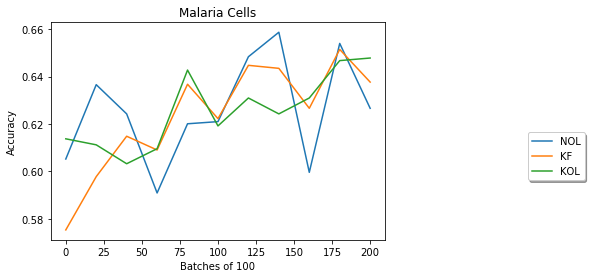

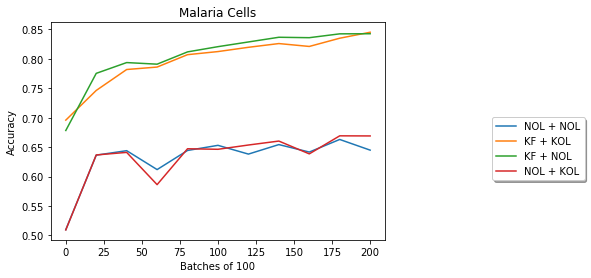

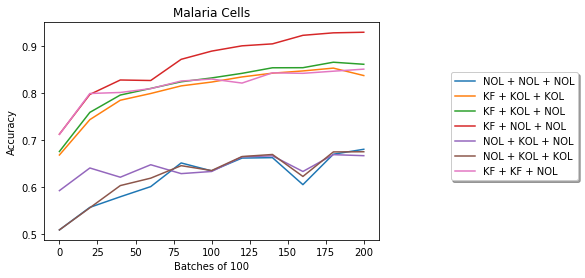

In [218]:
topnet.plot_results(results=results, dataset='Malaria Cells',item='accuracies', nLayers=3, separateByLayerCount=True)

## Load Cats & Dogs Data

In [227]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'
device = torch.device("cuda:0")

class DogsVSCats():
    IMG_SIZE = 50
    CATS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])                  
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                            
                except Exception as e:
                    #print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save(datadir + "altered/catdog_training_data.npy", self.training_data)
        
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
training_data = np.load(datadir+"altered/catdog_training_data.npy", allow_pickle=True)

X = np.array([i[0] for i in training_data])
X = X/255.0
y = np.array([i[1] for i in training_data])
X = X.astype(np.float32)
y = y.astype(np.float32)

In [228]:
n = np.arange(X.shape[0])
np.random.shuffle(n)
X = X[n]
y = y[n]
train_X , test_X , train_y , test_y = train_test_split(X , y , 
                                            test_size = 0.2 ,
                                            random_state = 1)

train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
# # i = Image.fromarray(X[0])


## Build configs for cats and dogs

In [229]:
for name, config in configs.items():
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['dataset']='Cats vs Dogs'
    config['epochs']=1

## Run

In [230]:
results['Cats Vs Dogs'] = topnet.run_configs(configs, None)

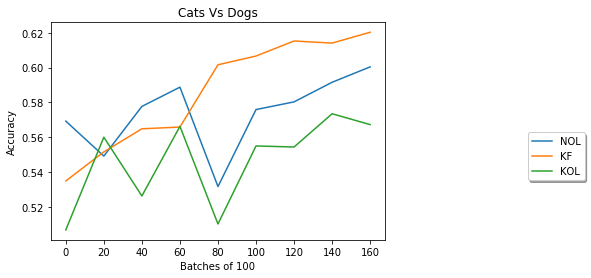

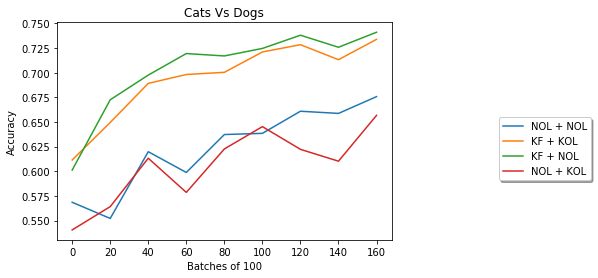

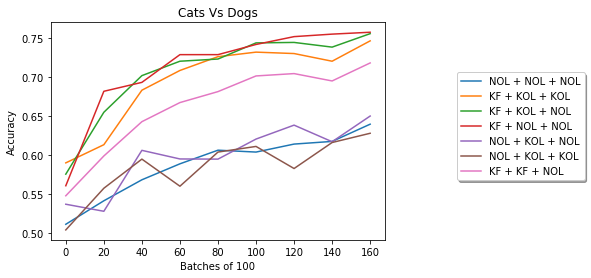

In [232]:
topnet.plot_results(results=results, dataset='Cats Vs Dogs',item='accuracies', nLayers=3, separateByLayerCount=True)

In [ ]:
# Samples to hit .75
dataset='Cats Vs Dogs'
configuration=results[dataset]
firstTo75=[]
for name, item in configuration.items():
    firstTo75.append((name, np.arange(len(item['accuracies']))[np.array(item['accuracies'])>=.7][0]))

name, area = zip(*firstTo75)
plt.bar(x=name,height=area)
plt.xticks(rotation=-30,ha="left")
plt.title(dataset)
plt.show()

## Load MNIST Numbers

In [233]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

train = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))

In [234]:
train_X = torch.tensor([np.array(i[0]) for i in train])
test_X = torch.tensor([np.array(i[0]) for i in test])
train_y = [i[1] for i in train]
test_y = [i[1] for i in test]

In [235]:
classes=np.unique(train_y)
test_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in test_y], dtype=torch.float32)
train_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in train_y], dtype=torch.float32)

## Build configs for MNIST Numbers

In [238]:
for name, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=10
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['dataset']='MNIST Numbers'

## Run MNIST

In [239]:
results['MNIST Numbers'] = topnet.run_configs(configs, None)

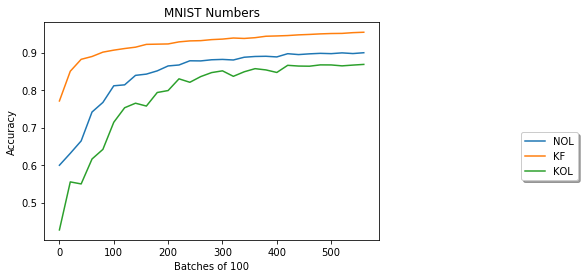

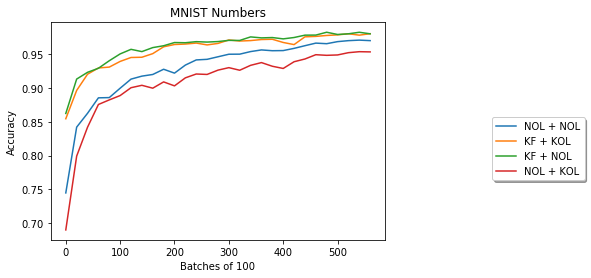

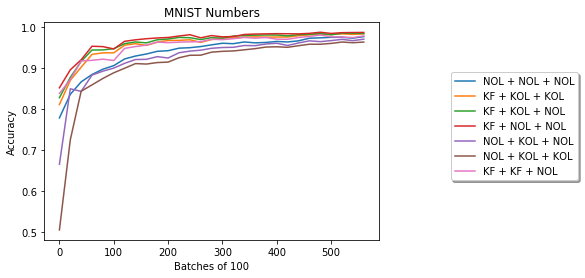

In [240]:
topnet.plot_results(results=results, dataset='MNIST Numbers',item='accuracies', nLayers=3, separateByLayerCount=True)

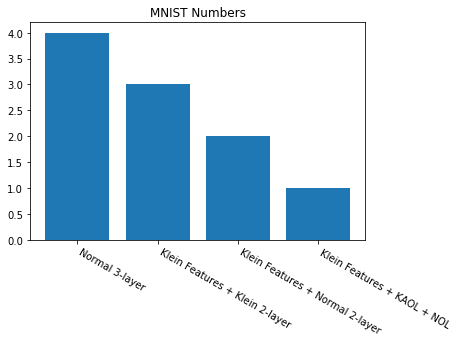

In [66]:
# Samples to hit .75
dataset='MNIST Numbers'
configuration=results[dataset]
firstTo75=[]
for name, item in configuration.items():
    firstTo75.append((name, np.arange(len(item['accuracies']))[np.array(item['accuracies'])>=.9][0]))

name, area = zip(*firstTo75)
plt.bar(x=name,height=area)
plt.xticks(rotation=-30,ha="left")
plt.title(dataset)
plt.show()

## SVHN Classifier

In [241]:
import scipy
datadir='/home/ephy/Projects/tda_convolution/data/original/SVHN/'
trainmat = scipy.io.loadmat(datadir+'train_32x32.mat')
testmat = scipy.io.loadmat(datadir+'test_32x32.mat')
classes=list(range(10))
train_y = np.array(trainmat['y'])
train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in train_y]), dtype=torch.float32)
test_y = np.array(testmat['y'])
test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in test_y]), dtype=torch.float32)
train_X=list()
for i in range(trainmat['X'].shape[3]):
    train_X.append(trainmat['X'][...,i])
train_X=np.array(train_X)
train_X=torch.tensor(np.dot(train_X[...,:3], [0.299, 0.587, 0.114]), dtype=torch.float32)

test_X=list()
for i in range(testmat['X'].shape[3]):
    test_X.append(testmat['X'][...,i])
test_X=np.array(test_X)
test_X=torch.tensor(np.dot(test_X[...,:3], [0.299, 0.587, 0.114]), dtype=torch.float32)

## Set configs for SVHN Classifier

In [245]:
for name, config in configs.items():
    config['imageDim']=(32,32)
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['dataset']='SVHN'
    config['learning_rate']=1e-6

In [246]:
results['SVHN'] = topnet.run_configs(configs, None)

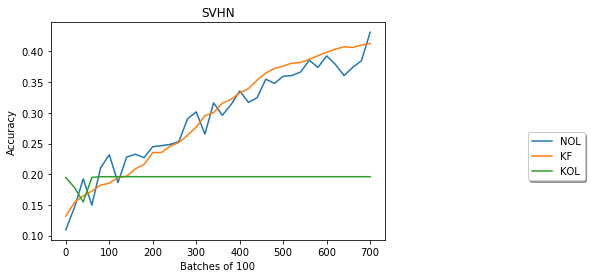

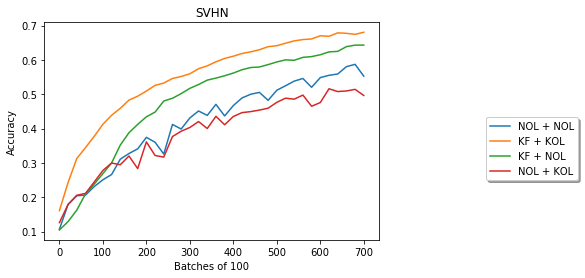

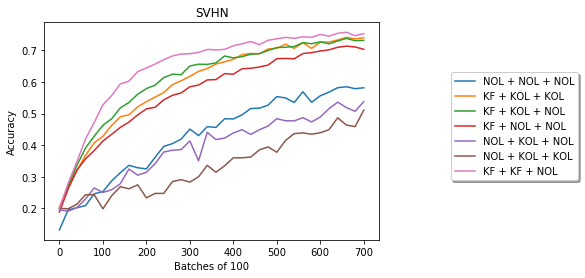

In [247]:
topnet.plot_results(results=results, dataset='SVHN',item='accuracies', nLayers=3, separateByLayerCount=True)

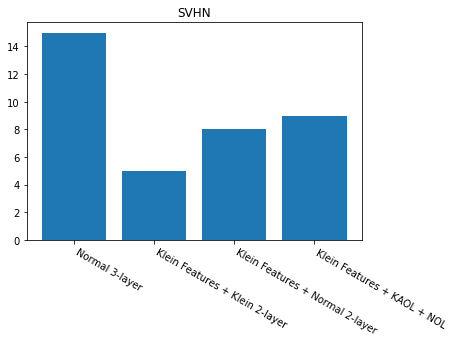

In [78]:
# Samples to hit .5
dataset='SVHN'
configuration=results[dataset]
firstTo75=[]
for name, item in configuration.items():
    firstTo75.append((name, np.arange(len(item['accuracies']))[np.array(item['accuracies'])>=.7][0]))

name, area = zip(*firstTo75)
plt.bar(x=name,height=area)
plt.xticks(rotation=-30,ha="left")
plt.title(dataset)
plt.show()

## Fashion MNIST

In [248]:
from mlxtend import data
fashion_train_X, fashion_train_y = data.loadlocal_mnist(
        images_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/train-images-idx3-ubyte', 
        labels_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/train-labels-idx1-ubyte')
fashion_test_X, fashion_test_y = data.loadlocal_mnist(
        images_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/t10k-images-idx3-ubyte', 
        labels_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/t10k-labels-idx1-ubyte')

fashion_train_X = torch.tensor(fashion_train_X.reshape(-1,28,28)/255, dtype=torch.float32)
fashion_test_X = torch.tensor(fashion_test_X.reshape(-1,28,28)/255, dtype=torch.float32)

nClasses=len(set(fashion_test_y))
classes=np.unique(fashion_test_y)
fashion_train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in fashion_train_y]), dtype=torch.float32)
fashion_test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in fashion_test_y]), dtype=torch.float32)

## Add Rotations

In [ ]:
# fashion_train_rotated_X = list()
# fashion_train_rotated_y = list()
# fashion_train_y_a = np.array(fashion_train_y)
# for i,x in enumerate(np.array(fashion_train_X)):
#     fashion_train_rotated_X.append(x)
#     fashion_train_rotated_X.append(np.array(Image.fromarray(x).rotate(15)))
#     fashion_train_rotated_X.append(np.array(Image.fromarray(x).rotate(-15)))
#     fashion_train_rotated_y.append(fashion_train_y_a[i])
#     fashion_train_rotated_y.append(fashion_train_y_a[i])
#     fashion_train_rotated_y.append(fashion_train_y_a[i])
    
# fashion_train_rotated_X = torch.tensor(fashion_train_rotated_X, dtype=torch.float32)
# fashion_train_rotated_y = torch.tensor(fashion_train_rotated_y, dtype=torch.float32)

In [249]:
for name, config in configs.items():
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=fashion_test_X
    config['test_y']=fashion_test_y
    config['train_y']=fashion_train_y
    config['train_X']=fashion_train_X
    config['dataset']='MNIST Fashion'
    config['epochs']=1
    config['learning_rate']=1e-5

In [250]:
results['MNIST Fashion'] = topnet.run_configs(configs, None)

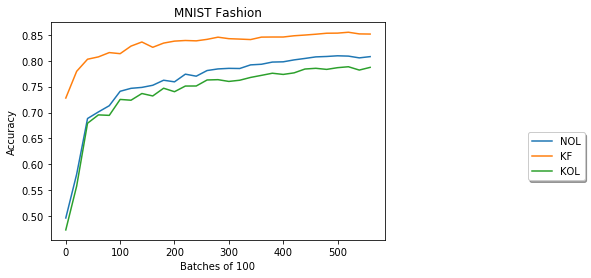

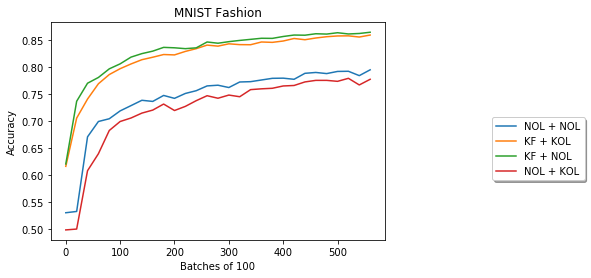

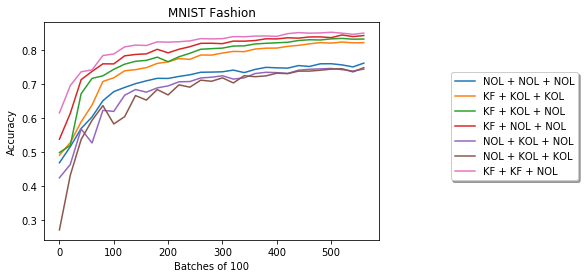

In [251]:
topnet.plot_results(results=results, dataset='MNIST Fashion',item='accuracies', nLayers=3, separateByLayerCount=True)

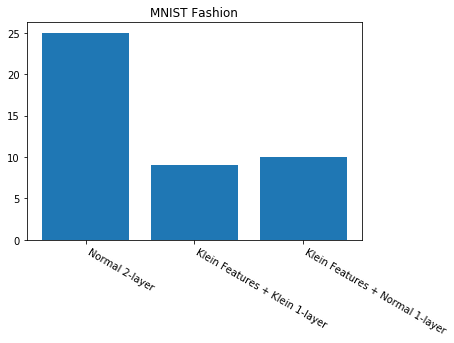

In [409]:
# Samples to hit .8
dataset='MNIST Fashion'
configuration=results[dataset]
firstTo75=[]
for name, item in configuration.items():
    firstTo75.append((name, np.arange(len(item['accuracies']))[np.array(item['accuracies'])>=.85][0]))

name, area = zip(*firstTo75)
plt.bar(x=name,height=area)
plt.xticks(rotation=-30,ha="left")
plt.title(dataset)
plt.show()

## Load CIFAR 10 Data

In [ ]:
# Get CIFAR Cats vs Dogs and compare generalizability there as well

In [422]:
buildData=False
datadir = '/home/ephy/Projects/tda_convolution/data/original/CIFAR/cifar-10-batches-py/'

In [421]:
if buildData:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_X = list()
    train_y = list()
    for batch in os.listdir(datadir):
        if 'data_batch' in batch:
            resp = unpickle(datadir+batch)
            for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
                train_X.append(np.moveaxis(item,0,-1)/255)
                train_y.append(resp[b'labels'][i])
    train_X = np.array(train_X)
    train_y = np.array(train_y)

    test_X = list()
    test_y = list()
    resp=unpickle(datadir+'test_batch')
    for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
        test_X.append(np.moveaxis(item,0,-1)/255)
        test_y.append(resp[b'labels'][i])

    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Go ahead and gray scale these
    test_X = np.dot(test_X[...,:3], [0.299, 0.587, 0.114])
    train_X = np.dot(train_X[...,:3], [0.299, 0.587, 0.114])

    nClasses=len(np.unique(train_y))
    test_y = np.array([np.eye(nClasses)[x] for x in test_y])
    train_y = np.array([np.eye(nClasses)[x] for x in train_y])
    
    np.save('../data/altered/CIFAR/train_X' , train_X)
    np.save('../data/altered/CIFAR/train_y' , train_y)
    np.save('../data/altered/CIFAR/test_X' , test_X)
    np.save('../data/altered/CIFAR/test_y' , test_y)
    
train_X=np.load('../data/altered/CIFAR/train_X.npy' )
train_y=np.load('../data/altered/CIFAR/train_y.npy' )
test_X=np.load('../data/altered/CIFAR/test_X.npy' )
test_y=np.load('../data/altered/CIFAR/test_y.npy' )
    
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

In [401]:
for name, config in configs.items():
    config['imageDim']=(32,32)
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['dataset']='CIFAR-10'
    config['learning_rate']=1e-5
    config['classes']=10

In [402]:
results['CIFAR-10']=topnet.run_configs(configs, None)

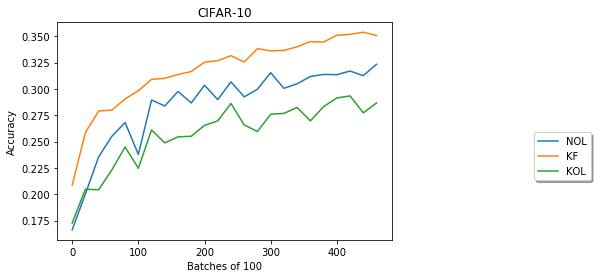

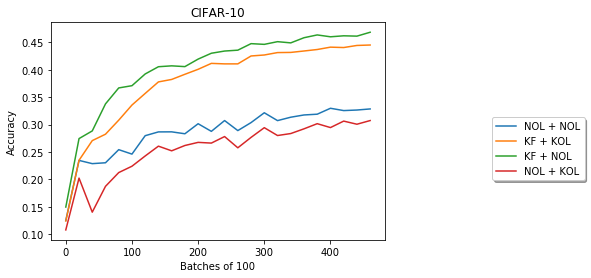

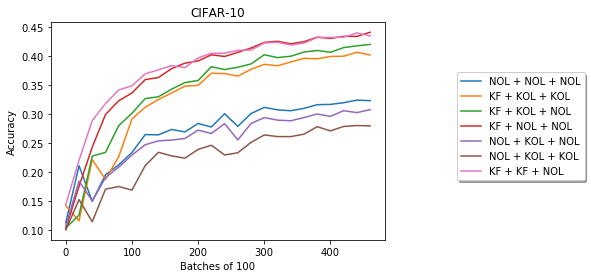

In [404]:
topnet.plot_results(results=results, dataset='CIFAR-10',item='accuracies', nLayers=3, separateByLayerCount=True)

In [498]:
configs=dict()

for threshold in np.arange(.35,.86,.1):
    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,[('Klein',8,8,5,threshold)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,5)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-6
    config['classes']=10
    config['imageDim']=(32,32)
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=1
    config['dataset']='CIFAR-10'
    config['loss_function']='nn.MSELoss'
    config['device'] = device
    configs['KF + KOL Threshold '+str(round(threshold,2))] = config
    
    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None,None]
    config['freeze_layers']=[True,False,False]
    config['membership_config']=[None,[('Klein',8,8,5,threshold)],[('Klein',8,8,5,threshold)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
    config['pools']=[None,None,None]
    config['activations']=[None, 'F.relu', 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(32,32)
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=1
    config['dataset']='CIFAR-10'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KF + KOL + KOL Threshold '+str(round(threshold,2))] = config
    
    config = dict()
    config['weights_config']=[None]
    config['freeze_layers']=[False]
    config['membership_config']=[[('Klein',8,8,3,threshold)]]
    config['convLayerSpecs']=[(1,64,3)]
    config['pools']=[None]
    config['activations']=['F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(32,32)
    config['test_X']=test_X
    config['test_y']=test_y
    config['train_y']=train_y
    config['train_X']=train_X
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=1
    config['dataset']='CIFAR-10'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KOL Threshold '+str(round(threshold,2))] = config

In [499]:
# test=dict()
test['CIFAR-10']=topnet.run_configs(configs, test['CIFAR-10'])

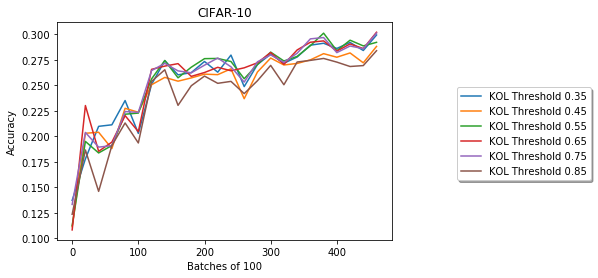

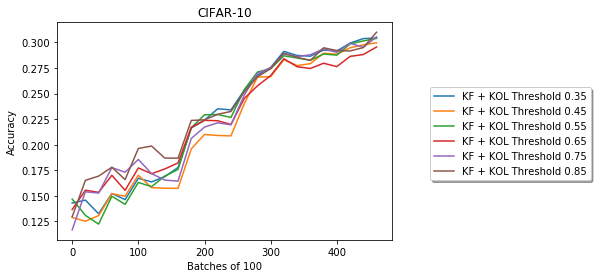

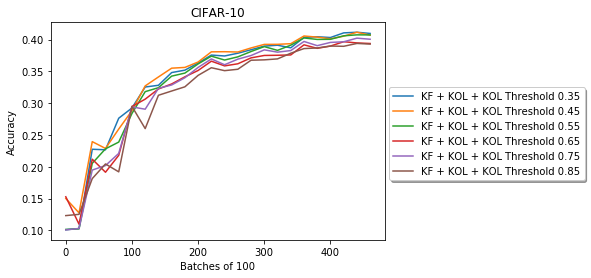

In [500]:
topnet.plot_results(results=test, dataset='CIFAR-10',item='accuracies', nLayers=3, separateByLayerCount=True)

In [557]:
configs=dict()
config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None,None,None,None]
config['freeze_layers']=[True,[('Klein',8,8,3,.45)],False,False,False]
config['membership_config']=[None,None,None,None,None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3),(64,64,3),(64,64,3),(64,64,3)]
config['pools']=[None,None,None,None,None]
config['activations']=[None, 'F.relu', 'F.relu','F.relu','F.relu']
config['learning_rate']=1e-4
config['classes']=10
config['imageDim']=(32,32)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=10
config['dataset']='CIFAR-10'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['5-Layer Custom'] = config

# config = dict()
# config['weights_config']=[None,None,None,None,None]
# config['freeze_layers']=[False,False,False,False,False]
# config['membership_config']=[None,None,None,None,None]
# config['convLayerSpecs']=[(1,64,3),(64,64,3),(64,64,3),(64,64,3),(64,64,3)]
# config['pools']=[None,None,None,None,None]
# config['activations']=['F.relu', 'F.relu', 'F.relu','F.relu','F.relu']
# config['learning_rate']=1e-4
# config['classes']=10
# config['imageDim']=(32,32)
# config['test_X']=test_X
# config['test_y']=test_y
# config['train_y']=train_y
# config['train_X']=train_X
# config['batchesPerTest']=20
# config['batchSize']=100
# config['epochs']=10
# config['dataset']='CIFAR-10'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['5-Layer Normal'] = config

# config = dict()
# config['weights_config']=[[('Klein',8,8,3,None)],None,None,None,None]
# config['freeze_layers']=[True,False,False,False,False]
# config['membership_config']=[None,None,None,None,None]
# config['convLayerSpecs']=[(1,64,3),(64,64,3),(64,64,3),(64,64,3),(64,64,3)]
# config['pools']=[None,None,None,None,None]
# config['activations']=[None, 'F.relu', 'F.relu','F.relu','F.relu']
# config['learning_rate']=1e-4
# config['classes']=10
# config['imageDim']=(32,32)
# config['test_X']=test_X
# config['test_y']=test_y
# config['train_y']=train_y
# config['train_X']=train_X
# config['batchesPerTest']=20
# config['batchSize']=100
# config['epochs']=10
# config['dataset']='CIFAR-10'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['5-Layer w/ KF'] = config

In [558]:
# r =dict()
r['CIFAR-10']=topnet.run_configs(configs, r['CIFAR-10'])

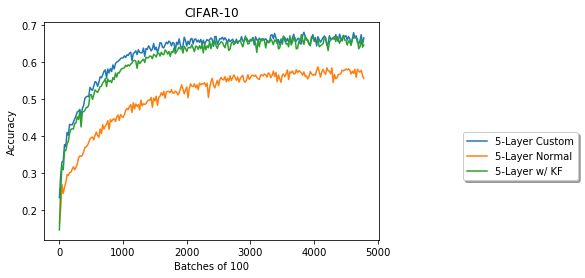

In [559]:
topnet.plot_results(results=r, dataset='CIFAR-10',item='accuracies')

In [ ]:
# Turns out this is too computationally intensive (just) in grayscale for the 2080TI

## Compare models on bird ID

In [ ]:
traindir = '/home/ephy/Projects/tda_convolution/data/original/birds/train'
image_dim=100
species = os.listdir(traindir)
training_data = list()
for i,s in enumerate(species):
    for f in os.listdir(os.path.join(traindir, s)):
        try:
            path = os.path.join(traindir, s, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
            img = cv2.resize(img, (image_dim,image_dim))
            training_data.append([np.array(img), s])                  
        except Exception as e:
            pass

testdir = '/home/ephy/Projects/tda_convolution/data/original/birds/test'
species = os.listdir(testdir)
test_data = list()
for s in species:
    for f in os.listdir(os.path.join(testdir, s)):
        try:
            path = os.path.join(testdir, s, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
            img = cv2.resize(img, (image_dim,image_dim))
            test_data.append([np.array(img), s])                  
        except Exception as e:
            pass

In [ ]:
bird_dict = dict()
for i, label in enumerate(np.unique(np.array([x[1] for i,x in enumerate(training_data)]))): bird_dict[label]=i

In [ ]:
images = np.array([x[0] for i,x in enumerate(training_data)])
birds_train_X = torch.tensor(images, dtype=torch.float32)
birds_train_y = np.array([bird_dict[x[1]] for i,x in enumerate(training_data)])
images = np.array([x[0] for x in test_data])
birds_test_X = torch.tensor(images, dtype=torch.float32)
birds_test_y = np.array([bird_dict[x[1]] for i,x in enumerate(test_data)])

# Randomize order of training set
n=np.arange(len(birds_train_X))
np.random.shuffle(n)
birds_train_X = birds_train_X[n]
birds_train_y = birds_train_y[n]

birds_test_y = torch.tensor(np.array([[int(n) for n in x==list(range(len(bird_dict.keys())))] for x in birds_test_y]), dtype=torch.float32)
birds_train_y = torch.tensor(np.array([[int(n) for n in x==list(range(len(bird_dict.keys())))] for x in birds_train_y]), dtype=torch.float32)

In [ ]:
plt.imshow(birds_train_X[0], cmap='gray')

In [ ]:
# Make some coppies of

In [ ]:
configs=dict()
# config = dict()
# config['weights_config']=[None,None]
# config['freeze_layers']=[False,False]
# config['membership_config']=[None,None]
# config['convLayerSpecs']=[(1,64,3),(64,64,5)]
# config['pools']=[None,None]
# config['activations']=['F.relu', 'F.relu']
# config['learning_rate']=1e-4
# config['classes']=len(bird_dict.keys())
# config['imageDim']=(image_dim,image_dim)
# config['test_X']=birds_test_X
# config['test_y']=birds_test_y
# config['train_y']=birds_train_y
# config['train_X']=birds_train_X
# config['batchesPerTest']=40
# config['batchSize']=100
# config['epochs']=5
# config['dataset']='Birds'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['Normal + Normal'] = config

config = dict()
config['weights_config']=[('Klein',8,8,3,None),None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,('Klein',8,8,5,.65)]
config['convLayerSpecs']=[(1,64,3),(64,128,5)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-4
config['classes']=len(bird_dict.keys())
config['imageDim']=(image_dim,image_dim)
config['test_X']=birds_test_X
config['test_y']=birds_test_y
config['train_y']=birds_train_y
config['train_X']=birds_train_X
config['batchesPerTest']=100
config['batchSize']=20
config['epochs']=1
config['dataset']='Birds'
config['loss_function']='nn.MSELoss'
config['device'] = device
config['convCoppies'] = [1,2]

configs['Klein + Klein Conv'] = config

# config = dict()
# config['weights_config']=[None,None]
# config['freeze_layers']=[False,False]
# config['membership_config']=[None,None]
# config['convLayerSpecs']=[(1,32,3),(32,32,5)]
# config['pools']=[None,None]
# config['activations']=['F.relu', 'F.relu']
# config['learning_rate']=1e-4
# config['classes']=len(bird_dict.keys())
# config['imageDim']=(image_dim,image_dim)
# config['test_X']=birds_test_X
# config['test_y']=birds_test_y
# config['train_y']=birds_train_y
# config['train_X']=birds_train_X
# config['batchesPerTest']=40
# config['batchSize']=100
# config['epochs']=5
# config['dataset']='Birds'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['Normal-32 + Normal-32 Conv'] = config

# config = dict()
# config['weights_config']=[('Klein',8,8,3,None)]
# config['freeze_layers']=[True]
# config['membership_config']=[None]
# config['convLayerSpecs']=[(1,64,3)]
# config['pools']=[None]
# config['activations']=[None]
# config['learning_rate']=1e-5
# config['classes']=len(bird_dict.keys())
# config['imageDim']=(image_dim,image_dim)
# config['test_X']=birds_test_X
# config['test_y']=birds_test_y
# config['train_y']=birds_train_y
# config['train_X']=birds_train_X
# config['batchesPerTest']=40
# config['batchSize']=100
# config['epochs']=5
# config['dataset']='Birds'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['Klein'] = config

# config = dict()
# config['weights_config']=[None]
# config['freeze_layers']=[False]
# config['membership_config']=[None]
# config['convLayerSpecs']=[(1,64,3)]
# config['pools']=[None]
# config['activations']=['F.relu']
# config['learning_rate']=1e-5
# config['classes']=len(bird_dict.keys())
# config['imageDim']=(image_dim,image_dim)
# config['test_X']=birds_test_X
# config['test_y']=birds_test_y
# config['train_y']=birds_train_y
# config['train_X']=birds_train_X
# config['batchesPerTest']=40
# config['batchSize']=100
# config['epochs']=5
# config['dataset']='Birds'
# config['loss_function']='nn.MSELoss'
# config['device'] = device

# configs['Normal'] = config

In [ ]:
# Work on saving out and loading in results...

In [ ]:
# results=dict()
# results['Birds'] = topnet.run_configs(configs, results['Birds'])
test = topnet.run_configs(configs, None)

In [ ]:
topnet.plot_results(results=results, dataset='Birds',item='accuracies', nLayers=2, separateByLayerCount=True)

In [ ]:
# np.save('/home/ephy/Projects/tda_convolution/data/bird_results', results)
# results = np.load('/home/ephy/Projects/tda_convolution/data/bird_results.npy', allow_pickle=True).item()

In [4]:
torch.cuda.memory_allocated()

0